<a href="https://colab.research.google.com/github/brittabeta/Learning-Sandbox/blob/main/App_User_Engagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# App User Engagement

Use segmentation to analyze app user behaviour. App users either kept the app (retained customer) or deleted the app (churn customer).

Goals
* Help the app developers and business understand users
* Improve user experience
* Drive user retention


# Importing Libraries

In [ ]:
# data loading and transformation tools
import pandas as pd
import numpy as np
# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# warnings and ignore for ease of reading notebook
import warnings
warnings.filterwarnings("ignore")
# set seed
random_seed = 42

# Loading Data

In [ ]:
# import app use data
path = '/content/userbehaviour.csv'
df = pd.read_csv(path)
df.head()

,userid,Average Screen Time,Average Spent on App (INR),Left Review,Ratings,New Password Request,Last Visited Minutes,Status
0,1001,17.0,634.0,1,9,7,2990,Installed
1,1002,0.0,54.0,0,4,8,24008,Uninstalled
2,1003,37.0,207.0,0,8,5,971,Installed
3,1004,32.0,445.0,1,6,2,799,Installed
4,1005,45.0,427.0,1,5,6,3668,Installed


In [ ]:
# obtain number of rows and columns
df.shape

(999, 8)

About the Data
* source: statso.io
* features:
* userid: id of user
* average screen time: average screen time of the user on the app, minutes
* average spent on app: average money spent on app, INR = Indian Rupee, 1 INR ~ 0.012 USD
* left review: user reviews, yes = 1, no = 0
* ratings: user rating of the app
* new password request: number of requests by user
* last visited minutes: minutes since last active 
* status: installed or deleted

# Data Cleaning and Feature Engineering

In [ ]:
# check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   userid                      999 non-null    int64  
 1   Average Screen Time         999 non-null    float64
 2   Average Spent on App (INR)  999 non-null    float64
 3   Left Review                 999 non-null    int64  
 4   Ratings                     999 non-null    int64  
 5   New Password Request        999 non-null    int64  
 6   Last Visited Minutes        999 non-null    int64  
 7   Status                      999 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 62.6+ KB


In [ ]:
# check number of unique values per column
for col in df:
  print(col, df[col].nunique())

userid 999
Average Screen Time 51
Average Spent on App (INR) 606
Left Review 2
Ratings 11
New Password Request 15
Last Visited Minutes 938
Status 2


In [ ]:
# get values for status column
df.Status.value_counts()

Installed      916
Uninstalled     83
Name: Status, dtype: int64

In [ ]:
# encode status column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Status'] = le.fit_transform(df['Status'])
mapping = dict(zip(le.classes_, range(0, len(le.classes_))))
print(mapping)

{'Installed': 0, 'Uninstalled': 1}


In [ ]:
# obtain descriptive statistics 
df.describe()

,userid,Average Screen Time,Average Spent on App (INR),Left Review,Ratings,New Password Request,Last Visited Minutes,Status
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,1500.000000,24.390390,424.415415,0.497497,6.513514,4.941942,5110.898899,0.083083
std,288.530761,14.235415,312.365695,0.500244,2.701511,2.784626,8592.036516,0.276146
min,1001.000000,0.000000,0.000000,0.000000,0.000000,1.000000,201.000000,0.000000
25%,1250.500000,12.000000,96.000000,0.000000,5.000000,3.000000,1495.500000,0.000000
50%,1500.000000,24.000000,394.000000,0.000000,7.000000,5.000000,2865.000000,0.000000
75%,1749.500000,36.000000,717.500000,1.000000,9.000000,7.000000,4198.000000,0.000000
max,1999.000000,50.000000,998.000000,1.000000,10.000000,15.000000,49715.000000,1.000000


Look at relationships and distribution in those retained (0) vs churn (1)

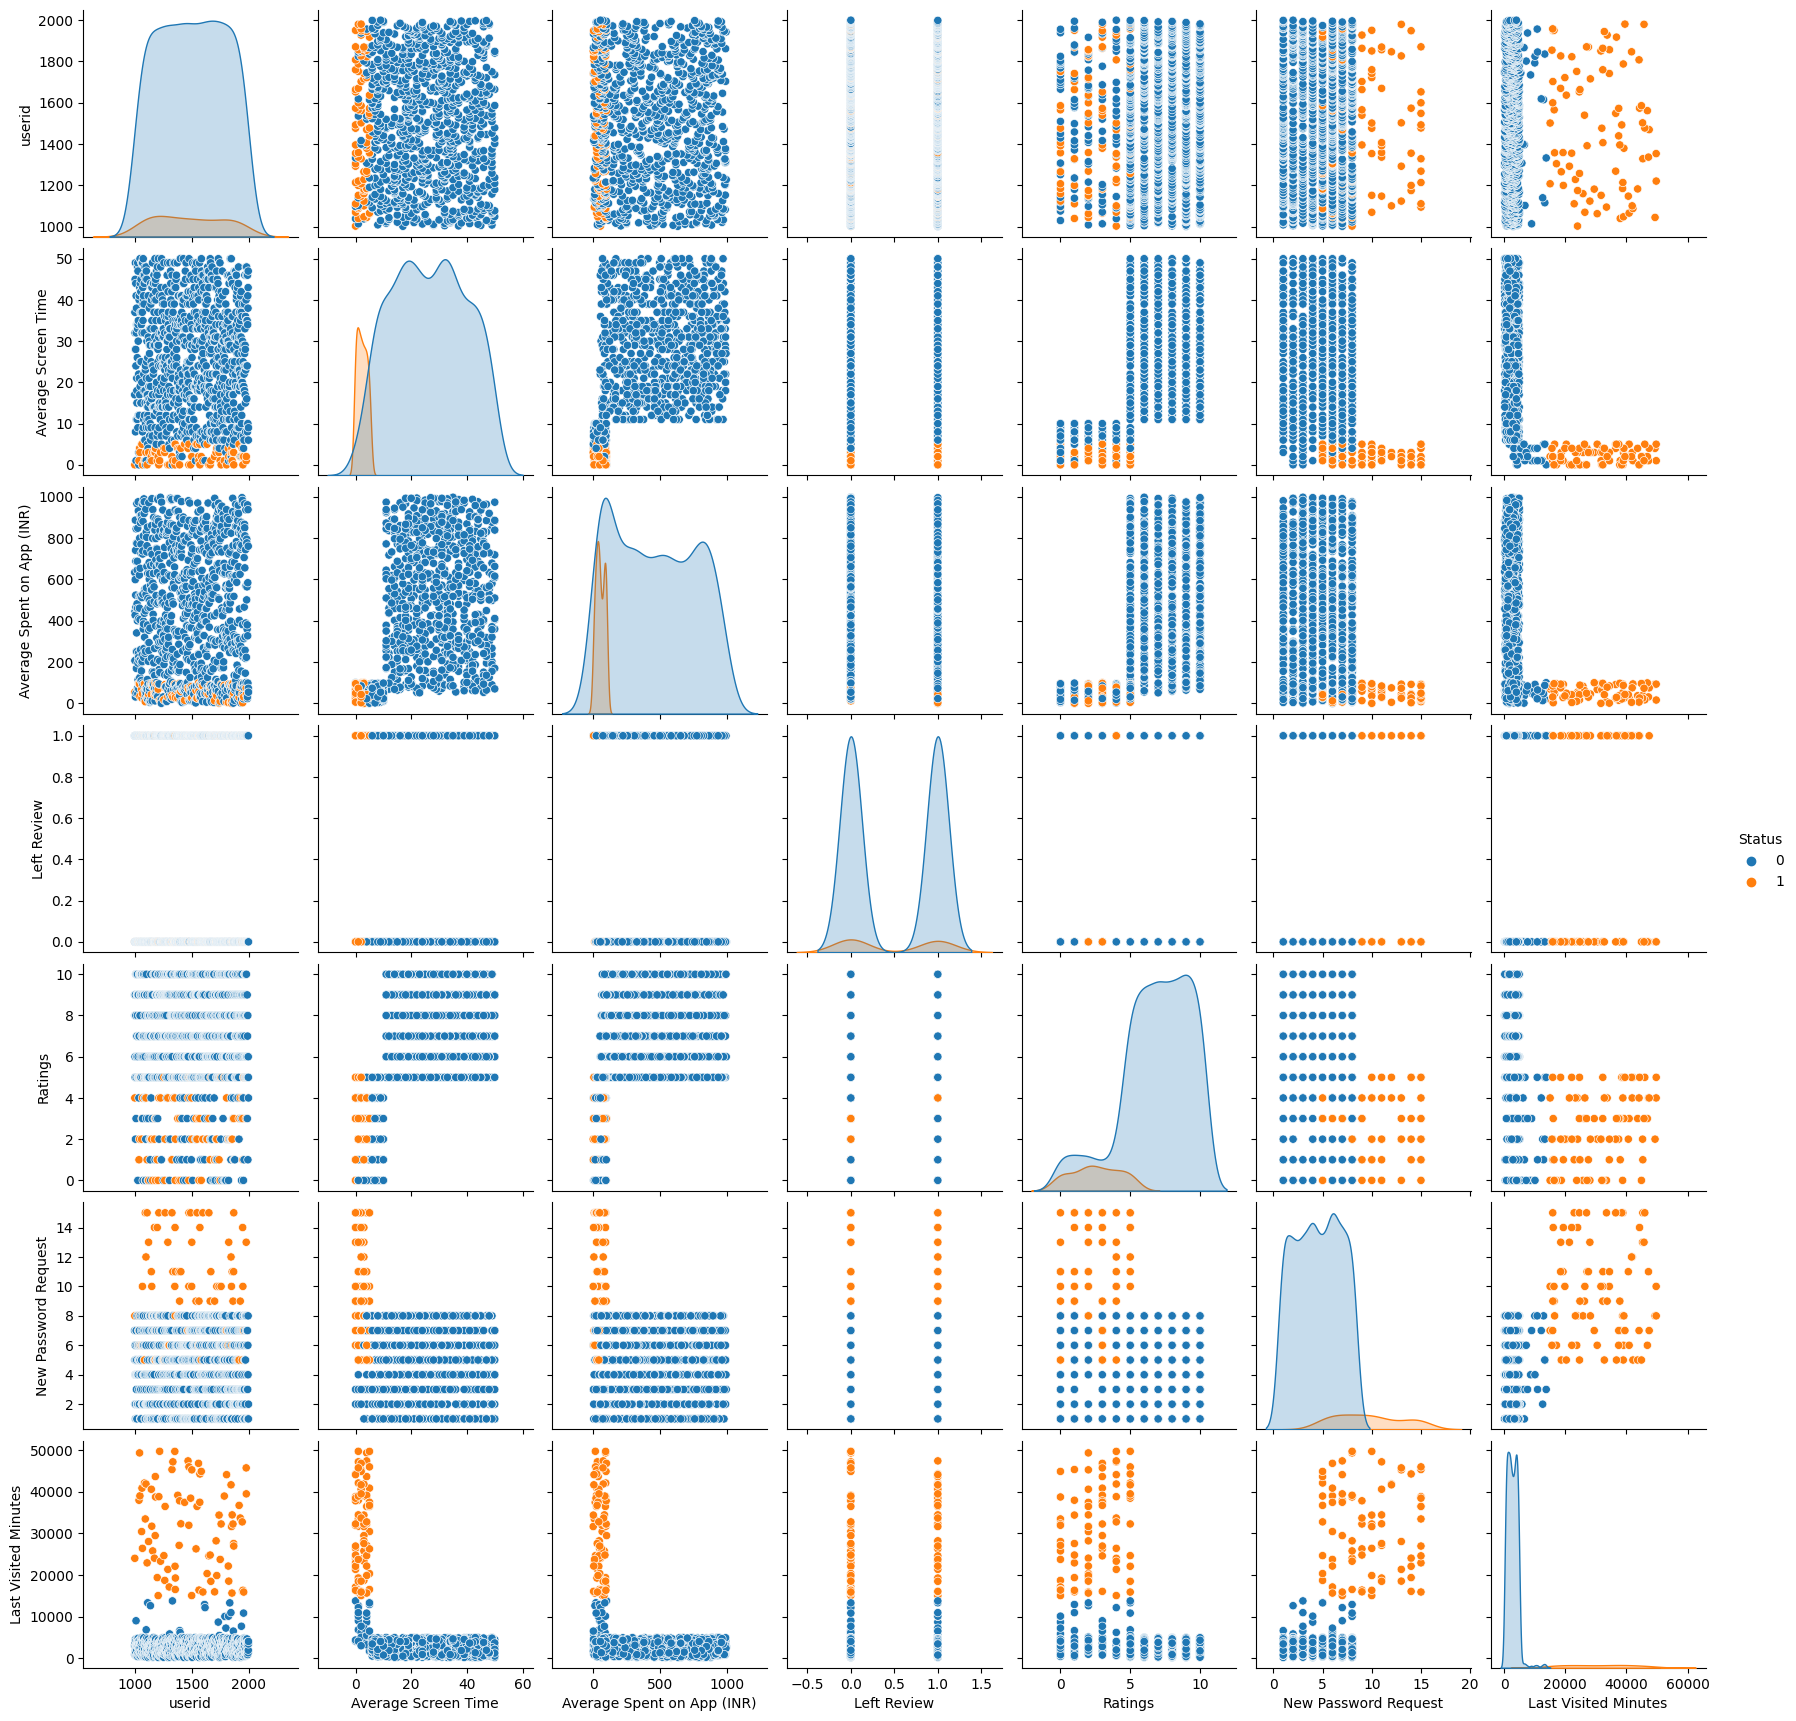

In [ ]:
sns.pairplot(data=df, hue = 'Status')

Distributions

Average Screen Time
* Churn user screen time is less than the majority of retained users, with screen times concentrated between ~ 0 and 10 minutes

Average Spent on App (INR)
* Churn user spending is less than the majority of retained users, with amount spent ~ 0 INR

Left Review
* Churn users left fewer reviews than retained users

Ratings
* Churn users rated the app at 5 or less, while retained users more commonly rated the app 5 or greater

New Password Request
* Churn users made had higher maximum reset requests, while retained users made fewer than 10 requests

Last Visited Minutes
* Churn users of course have not used the app as they no longer have it installed; retained customers have a trailing subset that have not utilized the app in some time.


# Preprocessing

In [ ]:
# scaling the data, seperate into features and target
target = df['Status']
data = df[["Average Screen Time", "Left Review", 
                        "Ratings", "Last Visited Minutes", 
                        "Average Spent on App (INR)", 
                        "New Password Request"]]

from sklearn.preprocessing import MinMaxScaler
for i in data.columns:
    MinMaxScaler(i)

# KMeans Estimator

Place each user into a cluster.

n_clusters is the number of clusters, the k-means clustering algorithm's hyperparameter k, which KMeans requires to calculate the clusters and label each user.  When the KMeans estimator is trained, the algorithm calculates for each cluster a centroid representing the cluster's center data point.

Once the model is fit/trained, the kmeans object contains: labels_ array with values 0 to n_clusters -1 indicating the clusters to which the users belong, and cluster_centers_ array in which each row represents a centroid.

In [ ]:
from sklearn.cluster import KMeans

If we used 2 as there are those that retain the app or do not, we would predict KMeans to cluster users into retained or churn.  

If we use 3, we can gather further insight.

In [ ]:
# create KMeans object called kmeans
kmeans = KMeans(n_clusters = 3, random_state = 11)

In [ ]:
# train kmeans estimator
kmeans.fit(data)

KMeans(n_clusters=3, random_state=11)

In [ ]:
# looking at how KMeans clustered our data
results = {'status_labels': target.values, 'kmeans_labels': kmeans.labels_}
result_df = pd.DataFrame(data=results)
result_df.head()

,status_labels,kmeans_labels
0,0,0
1,1,2
2,0,0
3,0,0
4,0,0


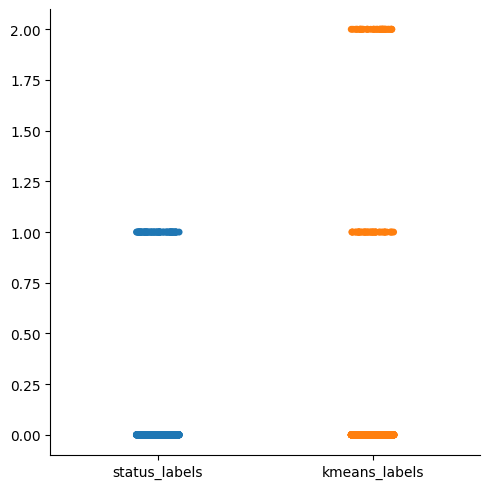

In [ ]:
sns.catplot(data = result_df)

Kmeans created two clusters 0 and 1 that correspond to status 0 (retained) and status 1 (churn user)...

Kmeans also created cluster 2 which is a new subset of app users...

In [ ]:
# investigate cluster 2
results2_df = df.join(result_df)
results2_df = results2_df.drop('status_labels', axis = 1)
results2_df.head()

,userid,Average Screen Time,Average Spent on App (INR),Left Review,Ratings,New Password Request,Last Visited Minutes,Status,kmeans_labels
0,1001,17.0,634.0,1,9,7,2990,0,0
1,1002,0.0,54.0,0,4,8,24008,1,2
2,1003,37.0,207.0,0,8,5,971,0,0
3,1004,32.0,445.0,1,6,2,799,0,0
4,1005,45.0,427.0,1,5,6,3668,0,0


In [ ]:
# create cluster subsets
cluster2_df = results2_df[results2_df['kmeans_labels'] == 2]
cluster2_df.head()

,userid,Average Screen Time,Average Spent on App (INR),Left Review,Ratings,New Password Request,Last Visited Minutes,Status,kmeans_labels
1,1002,0.0,54.0,0,4,8,24008,1,2
68,1069,0.0,48.0,1,4,10,26405,1,2
109,1110,0.0,23.0,0,1,15,22915,1,2
114,1115,5.0,20.0,1,5,5,13331,0,2
122,1123,3.0,44.0,1,0,13,28046,1,2


In [ ]:
# create cluster subsets
cluster0_df = results2_df[results2_df['kmeans_labels'] == 0]

cluster1_df = results2_df[results2_df['kmeans_labels'] == 1]


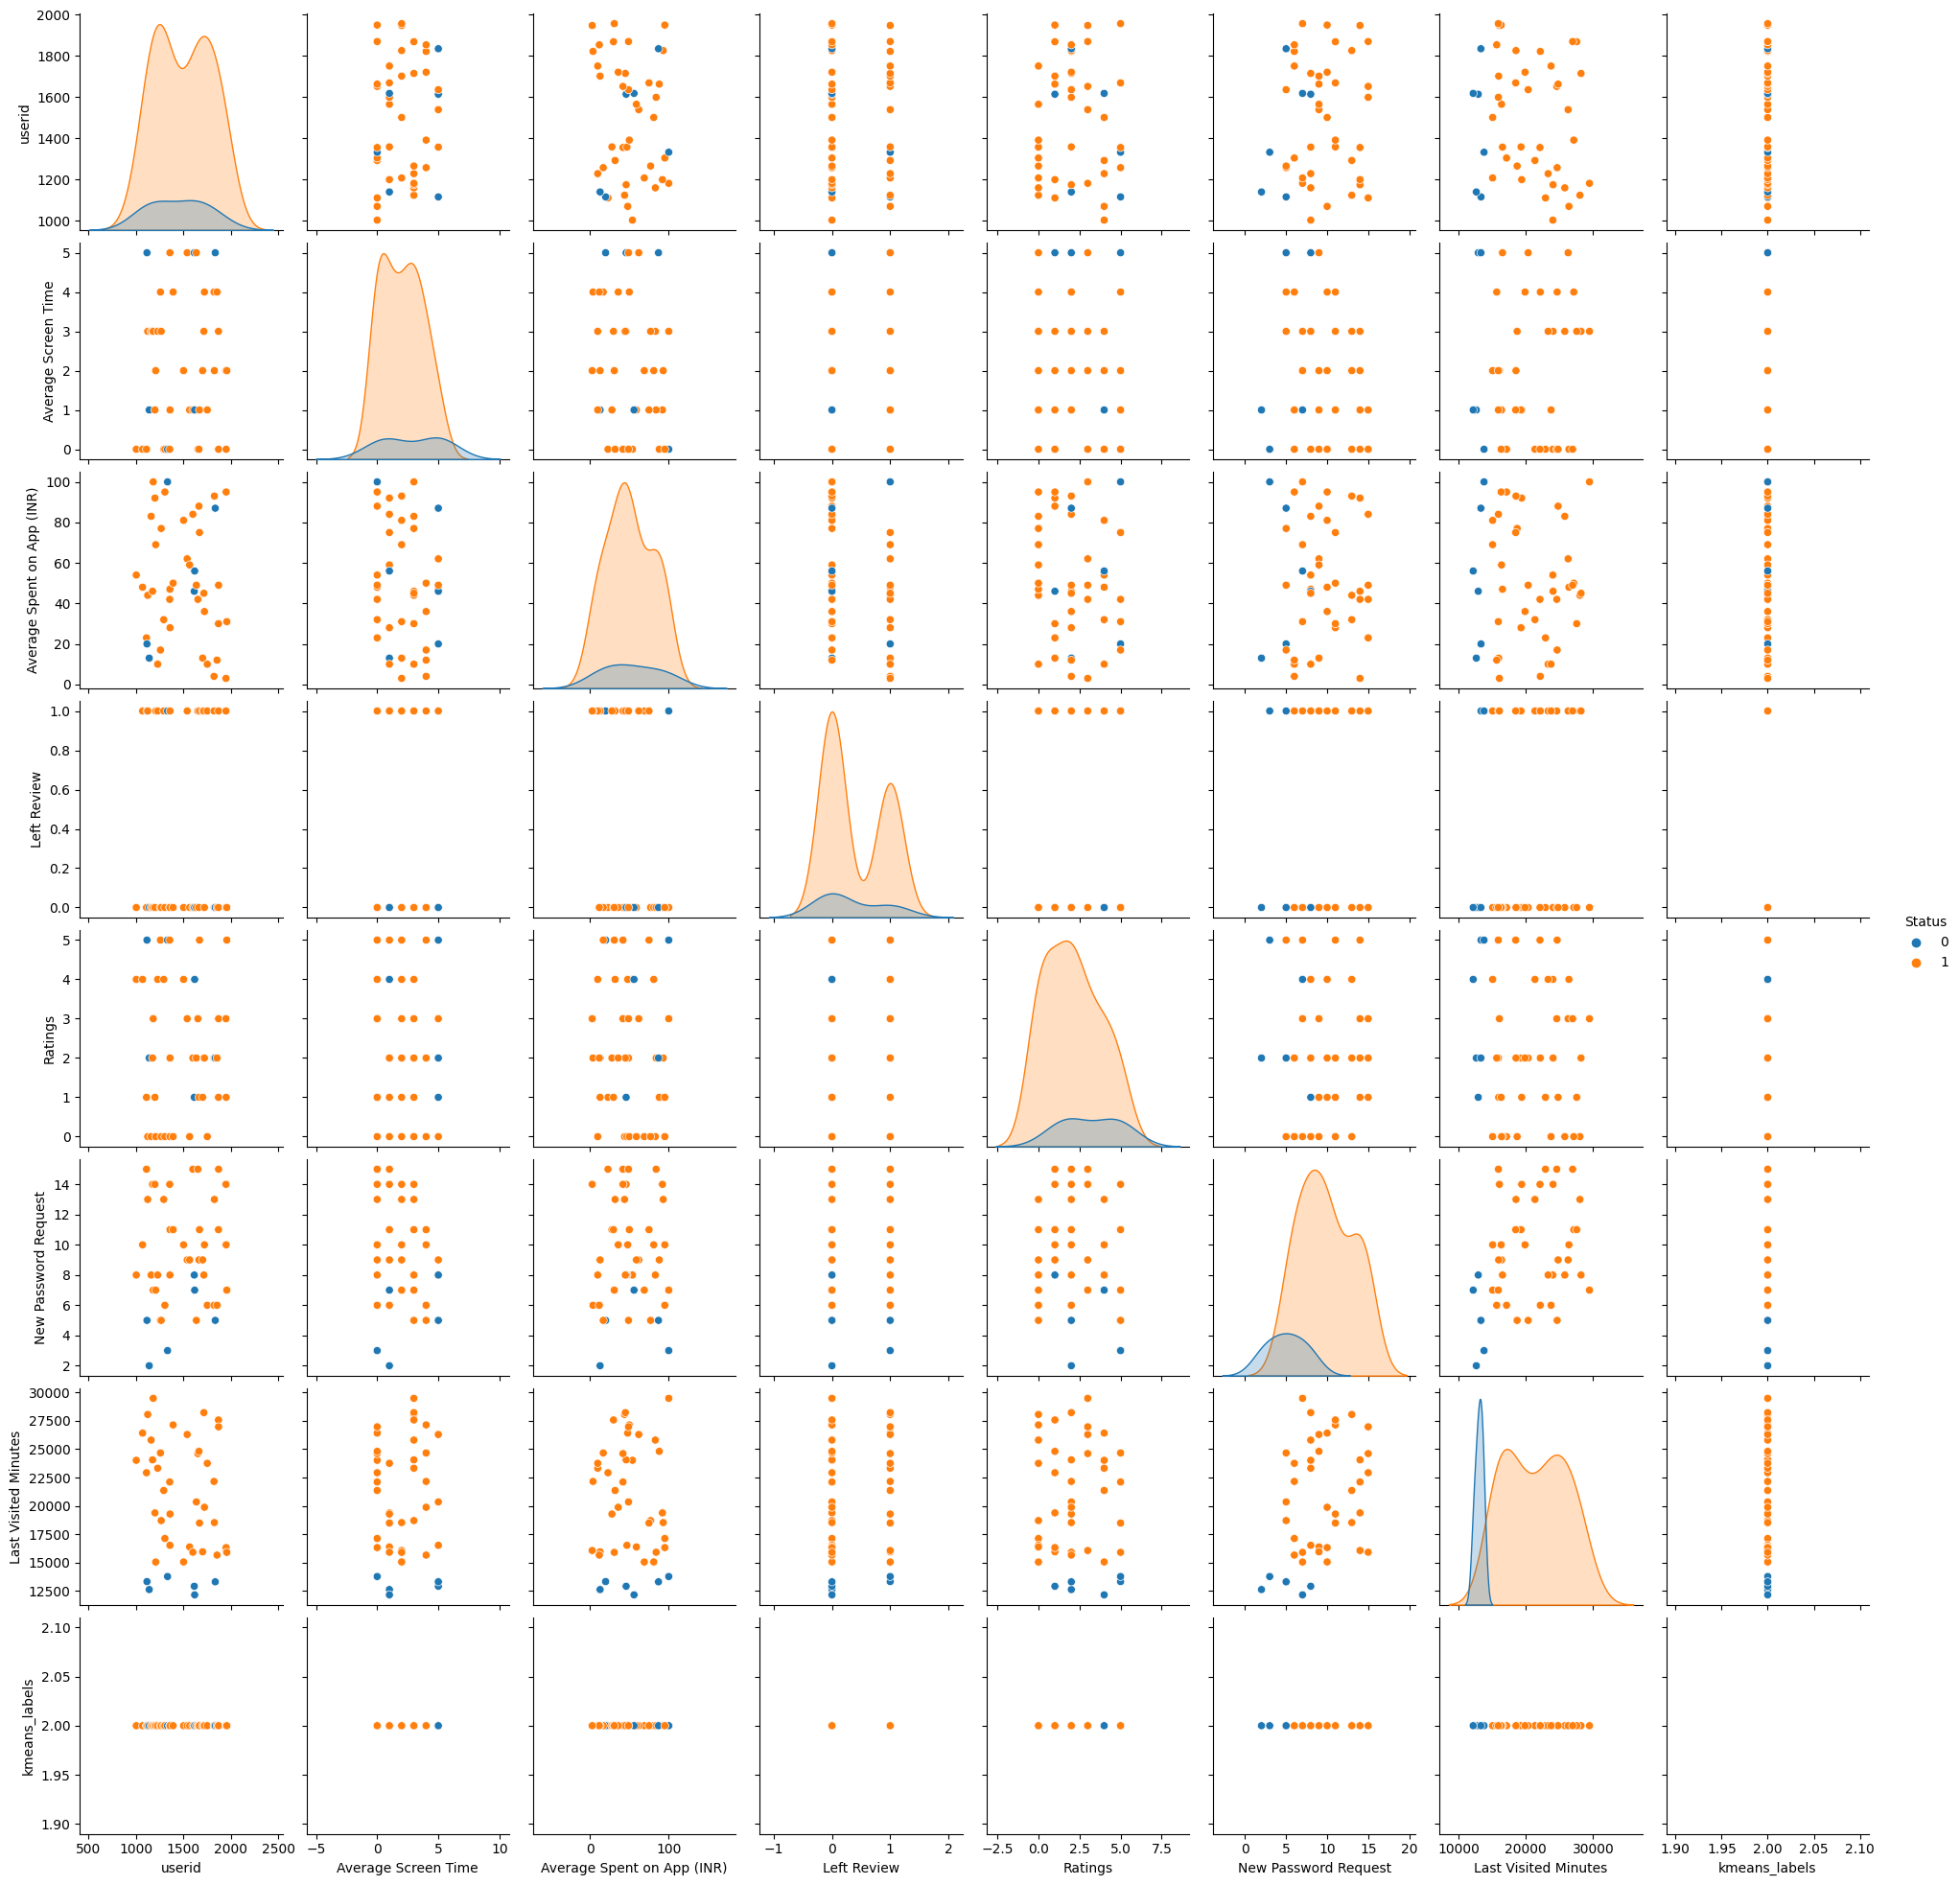

In [ ]:
# visualize cluster 2
sns.pairplot(cluster2_df, hue = 'Status')

About Cluster 2
* contains both churn and retained app users
* a defining feature: Last Visited Minutes
* secondary defining feature: New Password Request
* tertiary defining feature: Ratings

*defining feature refers to relationship with app user outcomes, churn or retained*

In [ ]:
print('Average Last Visited Minutes Cluster 2', cluster2_df['Last Visited Minutes'].mean())
print('Average New Password Requests Cluster 2', cluster2_df['New Password Request'].mean())

Average Last Visited Minutes Cluster 2 20277.295454545456
Average New Password Requests Cluster 2 9.204545454545455


In [ ]:
print('Average Last Visited Minutes Churn Users', cluster1_df['Last Visited Minutes'].mean())
print('Average New Password Requests Churn Users', cluster1_df['New Password Request'].mean())

Average Last Visited Minutes Churn Users 39574.75555555556
Average New Password Requests Churn Users 9.488888888888889


In [ ]:
print('Average Last Visited Minutes Retained Users', cluster0_df['Last Visited Minutes'].mean())
print('Average New Password Requests Retained Users', cluster0_df['New Password Request'].mean())

Average Last Visited Minutes Retained Users 2673.321978021978
Average New Password Requests Retained Users 4.510989010989011


In [ ]:
print('Average Rating Cluster 2', cluster2_df['Ratings'].mean())
print('Average Rating Churn Users', cluster1_df['Ratings'].mean())
print('Average Rating Retained Users', cluster0_df['Ratings'].mean())

Average Rating Cluster 2 2.227272727272727
Average Rating Churn Users 2.933333333333333
Average Rating Retained Users 6.897802197802198


Cluster 2 
* Average Last Visited Minutes: Less than Churn Users - Greater than Retained Users
* New Password Requests: Less than Churn Users - Greater than Retained Users

* Ratings: Cluster 2 average ratings were less than both Churn Users and Retained Users

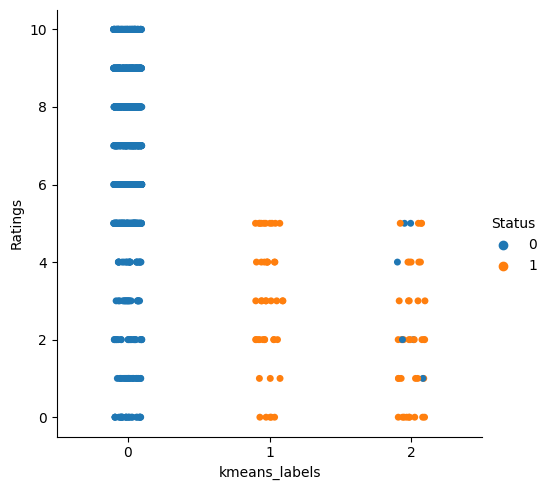

In [ ]:
sns.catplot(data = results2_df, x = 'kmeans_labels', y = 'Ratings', hue = 'Status')

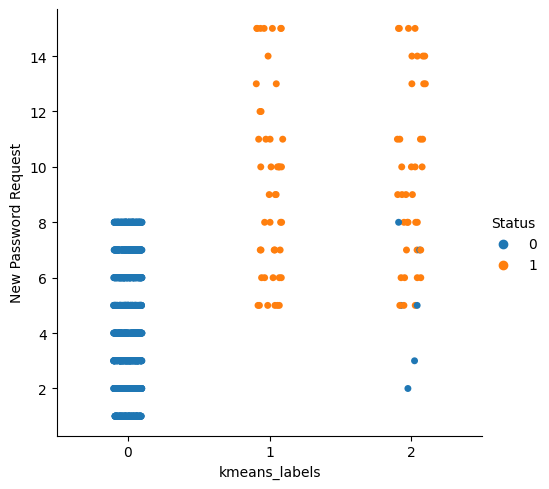

In [ ]:
sns.catplot(data = results2_df, x = 'kmeans_labels', y = 'New Password Request', hue = 'Status')

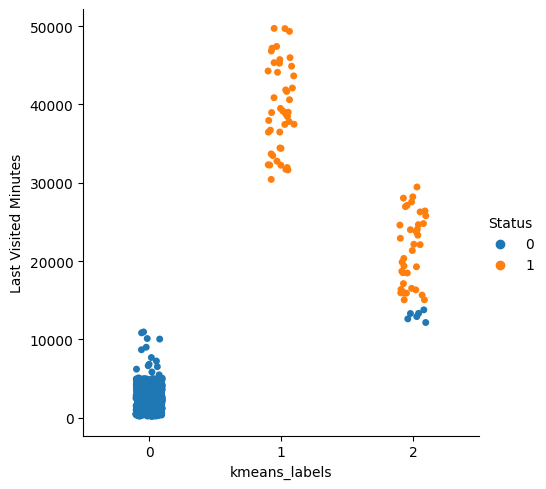

In [ ]:
sns.catplot(data = results2_df, x = 'kmeans_labels', y = 'Last Visited Minutes', hue = 'Status')

Investigate retained cluster 2 app users at risk of becoming churn users

In [ ]:
cluster2_df_retained = cluster2_df[cluster2_df['Status'] == 0]
cluster2_df_retained['Last Visited Minutes'].describe()

count        6.000000
mean     13021.666667
std        574.662220
min      12163.000000
25%      12701.750000
50%      13115.000000
75%      13325.750000
max      13777.000000
Name: Last Visited Minutes, dtype: float64

Investigate cluster 0 retained users at risk of becoming cluster 2 users

In [ ]:
cluster0_df['Last Visited Minutes'].describe()

count      910.000000
mean      2673.321978
std       1562.812285
min        201.000000
25%       1391.500000
50%       2598.000000
75%       3930.500000
max      10957.000000
Name: Last Visited Minutes, dtype: float64

*The 1st Quartile of Cluster 2 is marked at 12701.75 last visited minutes
*The 3rd Quartile of Cluster 0 is marked at 3930.50 last visited minutes
*This provides us with a range to trigger 'at risk of becoming churn users'

In [ ]:
risk_df = results2_df[results2_df['Last Visited Minutes'] <= 12701.75]
risk_df = risk_df[risk_df['Last Visited Minutes'] > 3930.50]

<Axes: xlabel='Last Visited Minutes', ylabel='Count'>

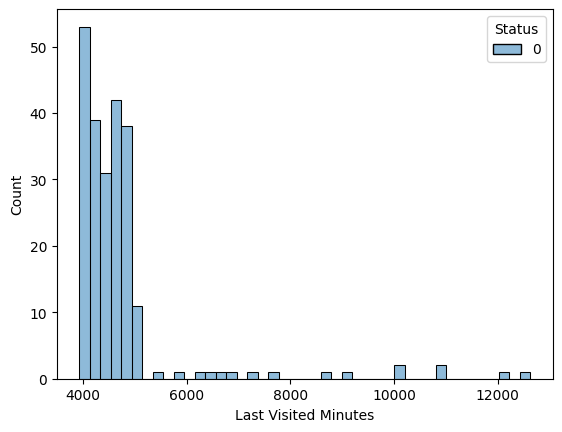

In [ ]:
sns.histplot(data=risk_df, x='Last Visited Minutes', hue = 'Status', fill = True)

# Summary

* Here we have identified something we can detect and act upon in currently retained users.
* If it has been more than 3930.50 minutes since their last app use, then they are at high risk of uninstalling the app.

# Next Steps
* An opportunity for further investigation is password reset request frequency.  
* Here the sequence of events is not clear.  It could be a result of not routinely using the app, or it could be associated with another aspect of the app user experience.
